<a href="https://colab.research.google.com/github/Hubert26/suicides_IPPAN/blob/main/ml_analize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Liblaries and settings

In [290]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import os

!pip install -U dtreeviz
import dtreeviz

from google.colab import files

#Ustawienie braku maksymalnej ilości wyświetlanych kolumn
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# avoid "Arial font not found warnings"
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

!pip install eli5


np.random.seed(42)

#Function definitions

##thresholds settings

In [291]:
# Ustawienie progów dla wysokiego ryzyka
risk_thresholds = [0.5, 0.9, 0.95, 0.99]

##plot_confusion_matrix

In [292]:
def plot_confusion_matrix(cm, model):
    # klasyfikacja binarna
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_1', 'true_0'])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index),
                                      colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(
        width=500,
        height=500,
        title=model+' Confusion Matrix',
        font_size=16,
        template='plotly_dark'
        )
    fig.show()
    return fig

##plot_roc_curve

**pogrubiony tekst**
 Receiver Operating Characteristic
1. True Positive Rate (TPR) = FP / (FP+TN)
2. False Positive Rate (FPR) = TP / (TP+FN)

In [293]:
def plot_roc_curve(y_test, y_pred, model):
    # Binary classification
    from sklearn.metrics import roc_curve
    fpr, tpr, tresh = roc_curve(y_test, y_pred, pos_label=1)

    fig = go.Figure(
        data=[
            go.Scatter(x=fpr, y=tpr,
                    line_color='red',
                    name='ROC Curve'),
            go.Scatter(x=[0, 1], y=[0, 1],
                    mode='lines',
                    line_dash='dash',
                    line_color='#F012BE')
        ],
        layout=go.Layout(xaxis_title='False Positive Rate',
                         yaxis_title='True Positive Rate',
                         title = model + ' ROC Curve',
                         showlegend=False,
                         template='plotly_dark',
                         width=700))
    fig.show()
    return fig


##model_validation


Precision (precyzja) = TP / (TP+FP): Ile obserwacji przewidzianych jako pozytywne jest w rzeczywistości pozytywne.

Recall (czułość) = TP / (TP+FN): Ile obserwacji z wszystkich pozywtywnych sklasyfikowaliśmy jako pozytywne.

F1-score: ważona średnia harmonicza między precyzją a czułością;

Support (wsparcie): liczba próbek, które należą do każdej z klas;

Accuracy (dokładność) = (TP+TN) /(TP+TN+FP+FN))

FPR (False Positive Rate) = FP / (FP+TN) [type I error]

FNR (False Negative Rate) = FN / (FN+TP) [type II error]

In [294]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_fscore_support

def model_validation(model, X_test, y_test, risk_thresholds = [0.5, 0.9, 0.95, 0.99]):
    # Sprawdzenie, czy y_test i X_test nie są puste
    if y_test is None or X_test is None or len(y_test) == 0 or len(X_test) == 0:
        raise ValueError("y_test and X_test must not be empty.")

    # Sprawdzenie rozmiarów X_test i y_test
    if len(X_test) != len(y_test):
        raise ValueError(f"Inconsistent number of samples: X_test has {len(X_test)} samples, y_test has {len(y_test)} samples.")

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # Obliczenie miar jakości modelu
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

    # Utworzenie ramki danych z wynikami
    model_results = pd.DataFrame({
        'recall': [recall],
        'accuracy': [accuracy],
        'precision': [precision],
        'f1': [f1],
    })

    # Obliczenie miar jakości modelu dla poszczególnych klas
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None, zero_division=0)

     # Tworzenie DataFrame z wynikami dla poszczególnych klas
    class_results = pd.DataFrame({
        'Class': np.unique(y_test),
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })

    # Dodanie wyników dla każdej klasy jako oddzielne kolumny
    for idx, class_ in enumerate(np.unique(y_test)):
        model_results[f'precision_{class_}'] = precision[idx]
        model_results[f'recall_{class_}'] = recall[idx]
        model_results[f'f1_{class_}'] = f1[idx]
        model_results[f'Support_{class_}'] = support[idx]

    for threshold in risk_thresholds:
        risk_metrics = risk_group_metrics(y_test, y_pred_prob, threshold)
        for key, value in risk_metrics.items():
            model_results[f'{key}_{threshold}'] = value

    return model_results

##bootstrap_auc

In [295]:
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

def bootstrap_auc(y_true, y_pred_prob, n_bootstraps=1000, alpha=0.95):
    # Upewnienie się, że y_true i y_pred_prob są jednowymiarowymi tablicami
    y_true = np.asarray(y_true).ravel()
    y_pred_prob = np.asarray(y_pred_prob).ravel()

    rng = np.random.RandomState(seed=42)
    bootstrapped_aucs = []

    for i in range(n_bootstraps):
        # Przykladowanie z powtórzeniami
        indices = rng.randint(0, len(y_pred_prob), len(y_pred_prob))
        if len(np.unique(y_true[indices])) < 2:
            # Przeskakujemy przypadki, gdzie brakuje jednej z klas w próbie bootstrapowej
            continue

        score = roc_auc_score(y_true[indices], y_pred_prob[indices])
        bootstrapped_aucs.append(score)

    if len(bootstrapped_aucs) == 0:
        raise ValueError("Wszystkie bootstrapowe próbki były nieprawidłowe.")

    sorted_scores = np.array(bootstrapped_aucs)
    sorted_scores.sort()

    # Obliczanie przedziału ufności
    lower_bound = np.percentile(sorted_scores, (1 - alpha) / 2 * 100)
    upper_bound = np.percentile(sorted_scores, (1 + alpha) / 2 * 100)

    return lower_bound, upper_bound

##risk_group_metrics

In [296]:
def risk_group_metrics(y_test, y_pred_prob, threshold):
    high_risk = y_pred_prob >= threshold
    y_pred_high_risk = np.zeros_like(y_pred_prob)
    y_pred_high_risk[high_risk] = 1

    y_test_high_risk = y_test[high_risk]
    y_pred_prob_high_risk = y_pred_prob[high_risk]

    # Sprawdzamy, czy mamy odpowiednią liczbę próbek do utworzenia macierzy pomyłek
    if len(np.unique(y_test_high_risk)) < 2:
        # Jeśli mamy tylko jedną klasę w danych wysokiego ryzyka, to zwracamy wartości domyślne
        tn = fp = fn = tp = np.nan
        risk_ratio = low_risk_positive_rate = high_risk_positive_rate = specificity = roc_score = lower = upper = fpr = fnr = np.nan
    else:
        cm = confusion_matrix(y_test, y_pred_high_risk)
        tn, fp, fn, tp = cm.ravel()

        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        high_risk_positive_rate = tp / (tp + fp) if (tp + fp) > 0 else 0
        low_risk_positive_rate = fn / (fn + tn) if (fn + tn) > 0 else 0
        risk_ratio = high_risk_positive_rate / low_risk_positive_rate if (low_risk_positive_rate) > 0 else 0

        roc_score = roc_auc_score(y_test_high_risk, y_pred_prob_high_risk)
        lower, upper = bootstrap_auc(y_test_high_risk, y_pred_prob_high_risk, n_bootstraps=1000, alpha=0.95)

    return {
        'class_0_pred': (y_pred_high_risk == 0).sum(),
        'class_1_pred': (y_pred_high_risk == 1).sum(),
        'AUROC': roc_score,
        'AUROClow': lower,
        'AUROCup': upper,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp,
        'fpr': fpr,
        'fnr': fnr,
        'specificity': specificity,
        'high_risk_positive_rate': high_risk_positive_rate,
        'low_risk_positive_rate': low_risk_positive_rate,
        'risk_ratio': risk_ratio
    }

##plot_learning_curve

In [297]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#Data exploration

In [298]:
df_raw = pd.read_csv('https://raw.githubusercontent.com/Hubert26/suicides_IPPAN/main/data/out_exploration_suicides.csv', delimiter=',', low_memory=False, index_col=False, dtype={'DateY': str, 'DateM': str,})


In [299]:
df_raw = df_raw.dropna(subset=['DateY'])

In [300]:
df_raw['DateY'].unique()

array(['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
       '2021', '2022', '2023'], dtype=object)

In [301]:
df_raw['DateM'].unique()

array(['05', '06', '10', '11', '12', '03', '04', '07', '08', '09', '01',
       '02'], dtype=object)

In [302]:
df_raw.shape

(127034, 27)

In [303]:
df_raw.head(5)

,Income,Age1,Fatal,Method,DateM,Gender,Education,AbuseInfo,DateY,ID_samobójcy,WorkInfo,Substance,Age2,Date,Place,CountContext,Marital,Context_Finances,Context_CloseDeath,Context_FamilyConflict,Context_Disability,Context_HeartBreak,Context_Crime,Context_SchoolWork,Context_MentalHealth,Context_Other,Context_HealthLoss
0,Dependent,07-12,0.0,Self-harm,05,F,Primary,Not,2013,"114771204,00",Student,Alco,00-18,5.2013,Forest,1.0,Single,0,0,0,0,0,0,0,0,1,0
1,Dependent,07-12,0.0,Other,06,F,Pre-primary,Not,2013,"114815301,00",Student,Sober,00-18,6.2013,Forest,1.0,Single,0,0,1,0,0,0,0,0,0,0
2,Dependent,07-12,1.0,Hanging,10,F,Pre-primary,Not,2013,"114936744,00",Student,Sober,00-18,10.2013,House,1.0,Single,0,0,0,0,0,0,0,0,0,0
3,Dependent,07-12,0.0,Other,10,M,Primary,Not,2013,"114944870,00",Student,Sober,00-18,10.2013,Other,1.0,Single,0,0,1,0,0,0,0,0,0,0
4,Dependent,07-12,1.0,Hanging,10,F,Pre-primary,Not,2013,"114948230,00",Student,Sober,00-18,10.2013,House,1.0,Single,0,0,0,0,0,0,0,0,0,0


##Filters and file name

['07-12',
 '13-18',
 '19-24',
 '25-29',
 '30-34',
 '35-39',
 '40-44',
 '45-49',
 '50-54',
 '55-59',
 '60-64',
 '65-69',
 '70-74',
 '75-79',
 '80-84',
 '85+']

 sorted(list(set(df_raw['Age1'])))

['00-18', '19-34', '35-64', '65+']

 sorted(list(set(df_raw['Age2'])))

['F', 'M']

[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

sorted(list(set(df_raw['DateY'])))

In [304]:
df_raw['Age'] = df_raw['Age2']

In [305]:
age_group = ['19-34']
gender = ['F', 'M']
year = sorted(list(set(df_raw['DateY'])))

In [306]:
age_group

['19-34']

In [307]:
age_group_file_title = "age_group_[" + ''.join(filter(str.isdigit, age_group[0][:3])) + "-" + ''.join(filter(str.isdigit, age_group[-1][-3:])) + "]"
year_group_file_title = "year_[" + str(year[0]) + '-' + str(year[-1]) + "]"

In [308]:
file_title = age_group_file_title + '_' + "gender_" + str(gender) + "_" + year_group_file_title
file_title

"age_group_[19-34]_gender_['F', 'M']_year_[2013-2023]"

##Data and NaN exploration

In [309]:
df_data = df_raw[df_raw['Age2'].isin(age_group) & df_raw['Gender'].isin(gender) & df_raw['DateY'].isin(year)]

In [310]:
df_data.shape

(39482, 28)

In [311]:
df_data['Fatal'].value_counts()

,count
Fatal,
0.0,25730
1.0,13752


In [312]:
##Brakujące dane
total = df_data.isnull().sum().sort_values(ascending=False)
percent = 100*(df_data.isnull().sum()/df_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [313]:
missing_data.head(5)

,Total,Percent
Income,0,0.0
Age1,0,0.0
Context_HealthLoss,0,0.0
Context_Other,0,0.0
Context_MentalHealth,0,0.0


##Dropping columns

In [314]:
df_data.columns

Index(['Income', 'Age1', 'Fatal', 'Method', 'DateM', 'Gender', 'Education',
       'AbuseInfo', 'DateY', 'ID_samobójcy', 'WorkInfo', 'Substance', 'Age2',
       'Date', 'Place', 'CountContext', 'Marital', 'Context_Finances',
       'Context_CloseDeath', 'Context_FamilyConflict', 'Context_Disability',
       'Context_HeartBreak', 'Context_Crime', 'Context_SchoolWork',
       'Context_MentalHealth', 'Context_Other', 'Context_HealthLoss', 'Age'],
      dtype='object')

In [315]:
df_data.drop(['ID_samobójcy', 'Date', 'CountContext'], inplace=True,	 axis=1, errors='ignore')

In [316]:
df_data.drop(['DateM', 'DateY'], inplace=True,	 axis=1, errors='ignore')

In [317]:
df_data.drop(['Age1', 'Age2'], inplace=True,	 axis=1, errors='ignore')

In [318]:
df_data.drop(['Age'], inplace=True,	 axis=1, errors='ignore')

In [319]:
#df_data.drop(['Gender'], inplace=True,	 axis=1, errors='ignore')

In [320]:
#df_data = df_data[['Method', 'Substance', 'Place']]

In [321]:
df_data.drop(['Context_Finances',
       'Context_CloseDeath', 'Context_FamilyConflict', 'Context_Disability',
       'Context_HeartBreak', 'Context_Crime', 'Context_SchoolWork',
       'Context_Other', 'Context_HealthLoss'], inplace=True,	 axis=1, errors='ignore')

In [322]:
df_data.columns

Index(['Income', 'Fatal', 'Method', 'Gender', 'Education', 'AbuseInfo',
       'WorkInfo', 'Substance', 'Place', 'Marital', 'Context_MentalHealth'],
      dtype='object')

###Label Encoding

In [323]:
from sklearn.preprocessing import LabelEncoder

# Inicjalizacja LabelEncoder
le = LabelEncoder()

Y = df_data['Fatal']
X = df_data.drop('Fatal', axis=1, errors='ignore')

categorical_cols = X.columns

# Zastosowanie label encoding do kolumn kategorycznych
for col in categorical_cols:
    X[col] = le.fit_transform(X[col])

In [324]:
# Podział na dane treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Obliczenie wag klas
class_weights = compute_class_weight('balanced', classes=np.unique(Y), y=Y)
# Utworzenie słownika wag klas
class_weight_dict = dict(zip(np.unique(Y), class_weights))

dtc = DecisionTreeClassifier(max_depth=None, min_samples_split=10, min_samples_leaf=10)
sample_weights = np.array([class_weight_dict[label] for label in y_train])
dtc.fit(X_train, y_train, sample_weight=sample_weights)

DecisionTreeClassifier(min_samples_leaf=10, min_samples_split=10)

In [337]:
dtc_results = model_validation(dtc, X, Y, risk_thresholds)

In [338]:
dtc_results

,recall,accuracy,precision,f1,precision_0.0,recall_0.0,f1_0.0,Support_0.0,precision_1.0,recall_1.0,f1_1.0,Support_1.0,class_0_pred_0.5,class_1_pred_0.5,AUROC_0.5,AUROClow_0.5,AUROCup_0.5,tn_0.5,fp_0.5,fn_0.5,tp_0.5,fpr_0.5,fnr_0.5,specificity_0.5,high_risk_positive_rate_0.5,low_risk_positive_rate_0.5,risk_ratio_0.5,class_0_pred_0.9,class_1_pred_0.9,AUROC_0.9,AUROClow_0.9,AUROCup_0.9,tn_0.9,fp_0.9,fn_0.9,tp_0.9,fpr_0.9,fnr_0.9,specificity_0.9,high_risk_positive_rate_0.9,low_risk_positive_rate_0.9,risk_ratio_0.9,class_0_pred_0.95,class_1_pred_0.95,AUROC_0.95,AUROClow_0.95,AUROCup_0.95,tn_0.95,fp_0.95,fn_0.95,tp_0.95,fpr_0.95,fnr_0.95,specificity_0.95,high_risk_positive_rate_0.95,low_risk_positive_rate_0.95,risk_ratio_0.95,class_0_pred_0.99,class_1_pred_0.99,AUROC_0.99,AUROClow_0.99,AUROCup_0.99,tn_0.99,fp_0.99,fn_0.99,tp_0.99,fpr_0.99,fnr_0.99,specificity_0.99,high_risk_positive_rate_0.99,low_risk_positive_rate_0.99,risk_ratio_0.99
0,0.776911,0.776911,0.813862,0.782106,0.911848,0.728061,0.809656,25730,0.630531,0.86831,0.73056,13752,20544,18938,0.666789,0.659196,0.674445,18733,6997,1811,11941,0.271939,0.13169,0.728061,0.630531,0.088152,7.152752,37135,2347,0.603369,0.570622,0.633014,25397,333,11738,2014,0.012942,0.853549,0.987058,0.858117,0.31609,2.714787,38582,900,0.577702,0.51732,0.634952,25646,84,12936,816,0.003265,0.940663,0.996735,0.906667,0.335286,2.70416,39173,309,0.5,0.5,0.5,25713,17,13460,292,0.000661,0.978767,0.999339,0.944984,0.343604,2.750212


In [325]:
# Pobranie atrybutów drzewa
tree = dtc.tree_

In [326]:
# Funkcja do zamiany nietypowych znaków na ich odpowiedniki HTML
def escape_html(text):
    return (text.replace("&", "&amp;")
                .replace("<", "&lt;")
                .replace(">", "&gt;")
                .replace('"', "&quot;")
                .replace("'", "&apos;"))

# Poprawienie nazw cech, zamiana nietypowych znaków na standardowe
cleaned_feature_names = [escape_html(feature) for feature in X.columns]

In [327]:
# Sprawdzenie unikalnych klas w danych
unique_classes = y_train.unique()  # Jeśli y_train to seria pandas
print(f"Unikalne klasy: {unique_classes}")

# Sprawdzenie rozmiaru tablicy y_train
print(f"Rozmiar y_train: {y_train.shape}")


Unikalne klasy: [1. 0.]
Rozmiar y_train: (27637,)


In [328]:
# Poprawiona wersja eksportu drzewa
class_names = {0: 'NotFatal', 1: 'Fatal'}
# Eksportowanie drzewa do pliku DOT
dot_data = export_graphviz(dtc, out_file=None, feature_names=cleaned_feature_names, filled=True, rounded=True, class_names=[class_names[i] for i in range(len(class_names))], special_characters=True, impurity=True, node_ids=True, rotate=True)

# Sprawdzenie, czy dot_data jest poprawne
if dot_data is None:
    raise ValueError("dot_data is None. There may be an issue with the export_graphviz function or its inputs.")


In [329]:
file_name = "TREE_graphviz_" + file_title
graph = graphviz.Source(dot_data)
graph.render(file_name, format="svg")
files.download(file_name + '.svg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [330]:
importances = dtc.feature_importances_

# Sortowanie cech według ważności
sorted_indices = importances.argsort()[::-1]
data = {'feature': [X.columns[index] for index in sorted_indices],
        'Mean_Decrease_Impurity': [importances[index] for index in sorted_indices]}

importances_df = pd.DataFrame(data)

In [331]:
importances_df

,feature,Mean_Decrease_Impurity
0,Method,0.802772
1,Place,0.045608
2,Substance,0.029383
3,Income,0.025697
4,Education,0.025212
5,Marital,0.021245
6,WorkInfo,0.020572
7,AbuseInfo,0.012025
8,Gender,0.009361
9,Context_MentalHealth,0.008125


 99%|===================| 23349/23690 [00:20<00:00]       

TypeError: only integer scalar arrays can be converted to a scalar index

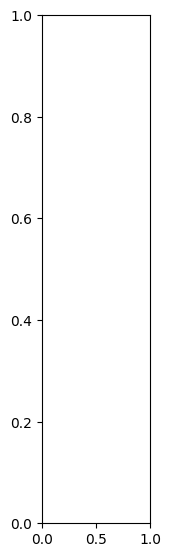

In [334]:
import shap

# SHAP values dla analizy ważności cech
explainer = shap.Explainer(dtc, X_train)
shap_values = explainer(X_test)

# Wykres SHAP
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [336]:
shap.dependence_plot("Gender", shap_values, X_test)

TypeError: loop of ufunc does not support argument 0 of type Explanation which has no callable conjugate method

In [333]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.4 MB/s eta 0:00:00


##Dummies

In [ ]:
data_dummies = pd.get_dummies(df_data)

In [ ]:
data_dummies.shape

(14628, 60)

In [ ]:
data_dummies = data_dummies.astype(np.uint8)

In [ ]:
data_dummies.head()

,Fatal,Context_Finances,Context_CloseDeath,Context_FamilyConflict,Context_Disability,Context_HeartBreak,Context_Crime,Context_SchoolWork,Context_MentalHealth,Context_Other,Context_HealthLoss,Income_Benefits,Income_Dependent,Income_NoSteady,Income_Steady,Method_Drowning,Method_Drugs,Method_Gas,Method_Hanging,Method_Jumping,Method_Other,Method_Poisoning,Method_Schooting,Method_Self-harm,Method_Vehicle,Education_Higher,Education_Pre-primary,Education_Primary,Education_Secondary,Education_Vocational,AbuseInfo_Alco,AbuseInfo_Alco&OtherSub,AbuseInfo_Not,AbuseInfo_OtherSub,WorkInfo_Agriculturalist,WorkInfo_Employed,WorkInfo_Unemployed,Substance_Alco,Substance_Alco&OtherSub,Substance_OtherSub,Substance_Sober,Place_Forest,Place_House,Place_Institution,Place_Isolation,Place_Other,Place_PoliceArmy,Place_Railway,Place_Road,Place_School,Place_UtilitySpaces,Place_WaterRes,Place_Work,Marital_Cohabitant,Marital_Divorced,Marital_Married,Marital_Separated,Marital_Single,Marital_Single,Marital_Widowed
112406,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
112407,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
112408,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
112409,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
112410,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


#DTC

In [ ]:
Y = data_dummies['Fatal']
X = data_dummies.drop('Fatal', axis=1, errors='ignore')

##Cross-validation

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold

# Obliczenie wag klas
class_weights = compute_class_weight('balanced', classes=np.unique(Y), y=Y)
# Utworzenie słownika wag klas
class_weight_dict = dict(zip(np.unique(Y), class_weights))

dtc = DecisionTreeClassifier(max_depth=None, min_samples_split=10, min_samples_leaf=10)

# Definicja walidacji krzyżowej
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

all_results = pd.DataFrame()

# Przeprowadzenie walidacji krzyżowej
for fold, (train_index, test_index) in enumerate(skf.split(X, Y), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Trenowanie modelu na danych treningowych z wagami
    sample_weights = np.array([class_weight_dict[label] for label in y_train])
    dtc.fit(X_train, y_train, sample_weight=sample_weights)

    # Walidacja modelu na danych testowych
    model_results = model_validation(dtc, X_test, y_test, risk_thresholds)

    model_results['features'] = X_train.shape[1]
    model_results['train_size'] = len(y_train)
    model_results['class_0_train_size'] = (y_train == 0).sum()
    model_results['class_1_train_size'] = (y_train == 1).sum()
    model_results['test_size'] = len(y_test)
    model_results['class_weight_0'] = class_weight_dict[0]
    model_results['class_weight_1'] = class_weight_dict[1]
    model_results['fold'] = str(fold)

    # Dodanie wyników do ramki danych
    all_results = pd.concat([all_results, model_results], ignore_index=True)


In [ ]:
# Obliczenie średnich dla każdej kolumny
mean_values = all_results.select_dtypes(include=np.number).mean()
# Dodanie średnich jako nowego wiersza
mean_values['fold'] = 'mean'  # Oznaczenie wiersza ze średnimi

all_results = pd.concat([all_results, pd.DataFrame(mean_values).T], ignore_index=True)

##Decision Tree Classifier

In [ ]:
dtc = DecisionTreeClassifier(
                              class_weight=class_weight_dict,
                              random_state=42,
                              max_depth=None,
                              min_samples_split=10,
                              min_samples_leaf=10)

dtc.fit(X, Y)

dtc_results = model_validation(dtc, X, Y, risk_thresholds)

In [ ]:
dtc_results['fold'] = 'final'
dtc_results['features'] = X.shape[1]
dtc_results['train_size'] = len(Y)
dtc_results['class_0_train_size'] = (Y == 0).sum()
dtc_results['class_1_train_size'] = (Y == 1).sum()
dtc_results['test_size'] = len(Y)
dtc_results['class_weight_0'] = class_weight_dict[0]
dtc_results['class_weight_1'] = class_weight_dict[1]

dtc_all_results = pd.concat([all_results, dtc_results], ignore_index=True)

##Feature validation

###Mean Decrease Impurity

In [ ]:
importances = dtc.feature_importances_

# Sortowanie cech według ważności
sorted_indices = importances.argsort()[::-1]
data = {'feature': [X.columns[index] for index in sorted_indices],
        'Mean_Decrease_Impurity': [importances[index] for index in sorted_indices]}

importances_df = pd.DataFrame(data)

####Grouped Importances

In [ ]:
# Zmienne wejściowe
features = X.columns

In [ ]:
# Tworzenie grup kategorii z dynamiczną obsługą braku zmiennych
category_groups = {
    category: [col for col in features if col.startswith(category)]
    for category in [
        'Method', 'Education', 'AbuseInfo', 'WorkInfo', 'Substance',
        'Place', 'Marital', 'Gender', 'Age', 'Context'
    ]
}

# Suma ważności dla każdej oryginalnej zmiennej kategorycznej
category_importances = {}

for category, columns in category_groups.items():
  if columns:
    category_importances[category] = importances_df[importances_df['feature'].isin(columns)]['Mean_Decrease_Impurity'].sum()

# Tworzenie DataFrame dla kategorii
category_importances_df = pd.DataFrame(list(category_importances.items()), columns=['Category', 'Mean_Decrease_Impurity'])

# Sortowanie według ważności
category_importances_df.sort_values(by='Mean_Decrease_Impurity', ascending=False, inplace=True)

# Wyświetlenie wyników
print(category_importances_df)


    Category  Mean_Decrease_Impurity
0     Method                0.733404
7    Context                0.079552
5      Place                0.051299
1  Education                0.035647
3   WorkInfo                0.028023
4  Substance                0.027879
6    Marital                0.024622
2  AbuseInfo                0.015044


###Permutation Importance


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

# Obliczenie Permutation Importance
perm = PermutationImportance(dtc, random_state=42).fit(X, Y)

# Pobranie wyników jako DataFrame
perm_df = eli5.explain_weights_df(perm, feature_names=list(X.columns))
# Zmiana nazw kolumn
perm_df = perm_df.rename(columns={'weight': 'Permutation_Importance_weight', 'std': 'Permutation_Importance_std'})

perm_df.drop(['Permutation_Importance_std'], inplace=True,	 axis=1, errors='ignore')

###Mean Decrease Accuracy

In [ ]:
# Obliczenie Mean Decrease Accuracy za pomocą cross_val_score
def mean_decrease_accuracy(model, X, y):
    baseline_accuracy = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()

    feature_importances = {}
    for feature in X.columns:
        X_permuted = X.copy()
        X_permuted[feature] = np.random.permutation(X[feature].values)
        permuted_accuracy = cross_val_score(model, X_permuted, y, cv=5, scoring='accuracy').mean()
        feature_importances[feature] = baseline_accuracy - permuted_accuracy

    return feature_importances

# Obliczenie Mean Decrease Accuracy dla cech
mda_results = mean_decrease_accuracy(dtc, X, Y)


In [ ]:
mda_df = pd.DataFrame(list(mda_results.items()), columns=['feature', 'Mean_Decrease_Accuracy'])

In [ ]:
merged_df = importances_df.merge(mda_df, on='feature', how='left')
dtc_feature_validation_df = merged_df.merge(perm_df, on='feature', how='left')

##Nodes info

In [ ]:
# Pobranie atrybutów drzewa
tree = dtc.tree_

# Pobranie ścieżki decyzji dla każdej próbki
node_indicator = dtc.decision_path(X_train)
leaf_indices = dtc.apply(X_train)

# Funkcja do obliczania głębokości węzłów
def compute_node_depths(tree):
    def get_depth(node_id, current_depth):
        depths[node_id] = current_depth
        if tree.children_left[node_id] != -1:
            get_depth(tree.children_left[node_id], current_depth + 1)
        if tree.children_right[node_id] != -1:
            get_depth(tree.children_right[node_id], current_depth + 1)

    depths = np.zeros(tree.node_count, dtype=np.int32)
    get_depth(0, 0)
    return depths

from sklearn.tree import _tree
def get_feature_name(tree, node_id, feature_names):
    """
    Zwraca nazwę cechy użytej do podziału w węźle.
    Jeśli węzeł jest liściem, zwraca 'Leaf'.
    """
    if tree.feature[node_id] != _tree.TREE_UNDEFINED:
        feature_index = tree.feature[node_id]
        return feature_names[feature_index]
    else:
        return 'Leaf'

# Obliczenie głębokości węzłów
node_depths = compute_node_depths(tree)

# Lista do przechowywania informacji o węzłach
nodes_info = []


# Iterowanie przez węzły
for node_id in range(tree.node_count):
    # Pobranie wskaźnika Gini
    gini = tree.impurity[node_id]

    # Pobranie liczby próbek w węźle
    samples = tree.n_node_samples[node_id]

    # Pobranie wartości dla każdej klasy
    values = tree.value[node_id][0]

    # Pobranie głębokości węzła
    depth = node_depths[node_id]

    # Sprawdzenie, czy węzeł jest liściem
    is_leaf = (tree.children_left[node_id] == -1) and (tree.children_right[node_id] == -1)

    # Pobranie cechy użytej do podziału (jeśli węzeł nie jest liściem)
    feature = get_feature_name(tree, node_id, X.columns)

    # Pobranie progu podziału (jeśli węzeł nie jest liściem)
    threshold = tree.threshold[node_id] if not is_leaf else -1

    # Utworzenie słownika z informacjami o węźle
    node_info = {
        'Node ID': node_id,
        'Gini': gini,
        'Samples': samples,
        'Values (Weighted)': values,
        'Sum of Values': sum(values),
        'Class Counts (Unweighted)': np.round(values / class_weights),
        'Depth': depth,
        'Is Leaf': is_leaf,
        'Feature': feature,
        'Threshold': threshold,
        'Children Left': tree.children_left[node_id],
        'Children Right': tree.children_right[node_id]
    }

    # Dodanie słownika do listy
    nodes_info.append(node_info)

# Utworzenie DataFrame z listy słowników
dtc_nodes_info_df = pd.DataFrame(nodes_info)

In [ ]:
dtc_nodes_info_df.head(5)

,Node ID,Gini,Samples,Values (Weighted),Sum of Values,Class Counts (Unweighted),Depth,Is Leaf,Feature,Threshold,Children Left,Children Right
0,0,0.500000,14628,"[7314.000000000488, 7313.9999999990405]",14628.000000,"[3494.0, 11134.0]",0,False,Method_Hanging,0.5,1,138
1,1,0.326698,4763,"[5463.520320549823, 1414.3202802226695]",6877.840601,"[2610.0, 2153.0]",1,False,Method_Jumping,0.5,2,111
2,2,0.238997,3508,"[4852.275901545757, 781.7190587389778]",5633.994960,"[2318.0, 1190.0]",2,False,Method_Schooting,0.5,3,100
3,3,0.214091,3293,"[4779.010303377461, 663.4758397700634]",5442.486143,"[2283.0, 1010.0]",3,False,Method_Drowning,0.5,4,85
4,4,0.185243,3013,"[4613.639381797594, 531.4375785881091]",5145.076960,"[2204.0, 809.0]",4,False,Place_Railway,0.5,5,78


##Path to Leaf info

In [ ]:
# Funkcja do uzyskania ścieżek do każdego liścia
def get_leaf_paths(tree, feature_names=None):
    tree_ = tree.tree_
    feature = tree_.feature
    threshold = tree_.threshold
    children_left = tree_.children_left
    children_right = tree_.children_right
    impurity = tree_.impurity
    n_node_samples = tree_.n_node_samples
    value = tree_.value

    leaf_info = []

    def recurse(node, path_conditions):
        if children_left[node] == children_right[node]:  # Jeśli jest to liść
            class_counts = value[node][0]
            leaf_class = np.argmax(class_counts)
            leaf_details = {
                'node_id': node,
                'gini': impurity[node],
                'samples': n_node_samples[node],
                '(1-gini)*samples': (1-impurity[node]) * n_node_samples[node],
                'leaf_class': leaf_class
            }
            leaf_details.update(path_conditions)
            leaf_info.append(leaf_details)
        else:
            if feature_names is not None:
                feature_name = feature_names[feature[node]]
            else:
                feature_name = feature[node]

            left_path_conditions = path_conditions.copy()
            left_path_conditions[feature_name] = 0
            recurse(children_left[node], left_path_conditions)

            right_path_conditions = path_conditions.copy()
            right_path_conditions[feature_name] = 1
            recurse(children_right[node], right_path_conditions)

    initial_conditions = {feature: np.nan for feature in feature_names}
    recurse(0, initial_conditions)

    return pd.DataFrame(leaf_info)

In [ ]:
# Uzyskanie nazw cech
feature_names = X_train.columns

# Uzyskanie ścieżek do każdego liścia
leaf_info_df = get_leaf_paths(dtc, feature_names)

In [ ]:
leaf_info_df.head(5)

,node_id,gini,samples,(1-gini)*samples,leaf_class,Method_Drowning,Method_Drugs,Method_Gas,Method_Hanging,Method_Jumping,Method_Other,Method_Poisoning,Method_Schooting,Method_Self-harm,Method_Vehicle,Substance_Alco,Substance_Alco&OtherSub,Substance_OtherSub,Substance_Sober,Place_Forest,Place_House,Place_Institution,Place_Isolation,Place_Other,Place_PoliceArmy,Place_Railway,Place_Road,Place_School,Place_UtilitySpaces,Place_WaterRes,Place_Work
0,14,0.182404,34,27.798255,0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN
1,16,0.114009,41,36.325613,0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,1.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN
2,17,0.150721,266,225.908269,0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,0.0,0.0,NaN,1.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN
3,18,0.037732,17,16.358555,0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,1.0,NaN,0.0,NaN,NaN
4,23,0.137853,49,42.245212,0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN


#RFC

In [ ]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

# Definicja siatki parametrów do RandomForestClassifier (opcjonalnie)
param_grid = {
    'n_estimators': 100,
    'max_features': 'sqrt',
    'max_depth': None,
    'min_samples_split': 10,
    'min_samples_leaf': 10
}

##Cross-validation

In [ ]:
# Stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=2)
all_models = []
class_weights_all = []
all_results = pd.DataFrame()

for fold, (train_index, test_index) in enumerate(skf.split(X, Y), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Oblicz wagi klas
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
    class_weights_all.append(class_weights_dict)

    # Inicjalizacja modelu RandomForestClassifier
    rf = RandomForestClassifier(random_state=42, **param_grid, class_weight=class_weights_dict)

    # Trenowanie modelu na zestawie treningowym
    rf.fit(X_train, y_train)

    # Dodanie do listy wytrenowanych modeli
    all_models.append(rf)

    # Walidacja modelu na danych testowych
    model_results = model_validation(rf, X_test, y_test, risk_thresholds)

    model_results['features'] = X_train.shape[1]
    model_results['train_size'] = len(y_train)
    model_results['class_0_train_size'] = (y_train == 0).sum()
    model_results['class_1_train_size'] = (y_train == 1).sum()
    model_results['test_size'] = len(y_test)
    model_results['class_weight_0'] = class_weight_dict[0]
    model_results['class_weight_1'] = class_weight_dict[1]
    model_results['fold'] = str(fold)

    # Dodanie wyników do ramki danych
    all_results = pd.concat([all_results, model_results], ignore_index=True)

In [ ]:
# Obliczenie średnich dla każdej kolumny
mean_values = all_results.select_dtypes(include=np.number).mean()
# Dodanie średnich jako nowego wiersza
mean_values['fold'] = 'mean'  # Oznaczenie wiersza ze średnimi

all_results = pd.concat([all_results, pd.DataFrame(mean_values).T], ignore_index=True)

In [ ]:
all_results

,recall,accuracy,precision,f1,precision_0,recall_0,f1_0,Support_0,precision_1,recall_1,f1_1,Support_1,class_0_pred_0.5,class_1_pred_0.5,AUROC_0.5,AUROClow_0.5,AUROCup_0.5,tn_0.5,fp_0.5,fn_0.5,tp_0.5,fpr_0.5,fnr_0.5,specificity_0.5,high_risk_positive_rate_0.5,low_risk_positive_rate_0.5,risk_ratio_0.5,class_0_pred_0.9,class_1_pred_0.9,AUROC_0.9,AUROClow_0.9,AUROCup_0.9,tn_0.9,fp_0.9,fn_0.9,tp_0.9,fpr_0.9,fnr_0.9,specificity_0.9,high_risk_positive_rate_0.9,low_risk_positive_rate_0.9,risk_ratio_0.9,class_0_pred_0.95,class_1_pred_0.95,AUROC_0.95,AUROClow_0.95,AUROCup_0.95,tn_0.95,fp_0.95,fn_0.95,tp_0.95,fpr_0.95,fnr_0.95,specificity_0.95,high_risk_positive_rate_0.95,low_risk_positive_rate_0.95,risk_ratio_0.95,class_0_pred_0.99,class_1_pred_0.99,AUROC_0.99,AUROClow_0.99,AUROCup_0.99,tn_0.99,fp_0.99,fn_0.99,tp_0.99,fpr_0.99,fnr_0.99,specificity_0.99,high_risk_positive_rate_0.99,low_risk_positive_rate_0.99,risk_ratio_0.99,features,train_size,class_0_train_size,class_1_train_size,test_size,class_weight_0,class_weight_1,fold
0,0.843314,0.843314,0.843253,0.843283,0.672206,0.671437,0.671821,1747,0.896929,0.897252,0.897091,5567,1745,5569,0.614174,0.590553,0.63932,1173,574,572,4995,0.328563,0.102748,0.671437,0.896929,0.327794,2.736262,7314,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7314,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7314,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,7314,1747,5567,7314,2.093303,0.656907,1
1,0.808039,0.808039,0.832745,0.815928,0.575186,0.751002,0.65144,1747,0.91357,0.825939,0.867547,5567,2281,5033,0.544123,0.516759,0.571685,1312,435,969,4598,0.248998,0.174061,0.751002,0.91357,0.424814,2.15052,7314,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7314,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7314,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,7314,1747,5567,7314,2.093303,0.656907,2
2,0.825677,0.825677,0.837999,0.829606,0.623696,0.711219,0.661631,1747.0,0.90525,0.861595,0.882319,5567.0,2013.0,5301.0,0.579148,0.553656,0.605502,1242.5,504.5,770.5,4796.5,0.288781,0.138405,0.711219,0.90525,0.376304,2.443391,7314.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7314.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7314.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,7314.0,1747.0,5567.0,7314.0,2.093303,0.656907,mean


##Random Forest Classifier

In [ ]:
# Uśrednienie wag klas
avg_class_weights = {}
for class_id in range(len(np.unique(Y))):
    avg_weight = np.mean([weights[class_id] for weights in class_weights_all])
    avg_class_weights[class_id] = avg_weight

# Połączenie wszystkich modeli w jeden model
final_rf = RandomForestClassifier(random_state=42, **param_grid, class_weight=avg_class_weights)

# Łączenie drzew z poszczególnych modeli
combined_estimators = []
for model in all_models:
    for tree in model.estimators_:
        combined_estimators.append(tree)

final_rf.estimators_ = combined_estimators

# Ostateczne dopasowanie modelu do całego zestawu danych
final_rf.fit(X, Y)

rf_results = model_validation(rf, X, Y, risk_thresholds)

In [ ]:
rf_results['fold'] = 'final'
rf_results['features'] = X.shape[1]
rf_results['train_size'] = len(Y)
rf_results['class_0_train_size'] = (Y == 0).sum()
rf_results['class_1_train_size'] = (Y == 1).sum()
rf_results['test_size'] = len(Y)
rf_results['class_0_weight'] = avg_class_weights[0]
rf_results['class_1_weight'] = avg_class_weights[1]

rf_all_results = pd.concat([all_results, rf_results], ignore_index=True)

##Feature validation

###Mean Decrease Impurity

In [ ]:
importances = rf.feature_importances_

# Sortowanie cech według ważności
sorted_indices = importances.argsort()[::-1]
data = {'feature': [X.columns[index] for index in sorted_indices],
        'Mean_Decrease_Impurity': [importances[index] for index in sorted_indices]}

importances_df = pd.DataFrame(data)

###Permutation Importance


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

# Obliczenie Permutation Importance
perm = PermutationImportance(dtc, random_state=42).fit(X, Y)

# Pobranie wyników jako DataFrame
perm_df = eli5.explain_weights_df(perm, feature_names=list(X.columns))
# Zmiana nazw kolumn
perm_df = perm_df.rename(columns={'weight': 'Permutation_Importance_weight', 'std': 'Permutation_Importance_std'})

perm_df.drop(['Permutation_Importance_std'], inplace=True,	 axis=1, errors='ignore')

###Mean Decrease Accuracy

In [ ]:
# Obliczenie Mean Decrease Accuracy dla cech
mda_results = mean_decrease_accuracy(rf, X, Y)


In [ ]:
mda_df = pd.DataFrame(list(mda_results.items()), columns=['feature', 'Mean_Decrease_Accuracy'])

In [ ]:
merged_df = importances_df.merge(mda_df, on='feature', how='left')
rf_feature_validation_df = merged_df.merge(perm_df, on='feature', how='left')

#Feature Count in risk groups

In [ ]:
# Utworzenie pustego DataFrame do przechowywania wyników
feature_count_df = pd.DataFrame()

# Przewidywanie prawdopodobieństw
pred_prob = rf.predict_proba(X)[:, 1]

for threshold in risk_thresholds:
    # Wybranie przykładów o wysokim ryzyku
    high_risk_idx = pred_prob >= threshold
    high_risk_X = X[high_risk_idx]

    if not high_risk_X.empty:
        # Obliczenie wystąpienia każdej cechy w grupach wysokiego ryzyka
        high_risk_features_sum = high_risk_X.sum()

        # Dodanie kolumny threshold do wyników
        high_risk_features_sum['threshold'] = threshold

        high_risk_features_sum['samples'] = high_risk_X.shape[0]

        # Dodanie wyników do feature_count_df
        feature_count_df = pd.concat([feature_count_df, high_risk_features_sum.to_frame().T], ignore_index=True)
    else:
        print(f"Brak przykładów o wysokim ryzyku dla progu {threshold}")



Brak przykładów o wysokim ryzyku dla progu 0.9
Brak przykładów o wysokim ryzyku dla progu 0.95
Brak przykładów o wysokim ryzyku dla progu 0.99


In [ ]:
feature_count_df

,Method_Drowning,Method_Drugs,Method_Gas,Method_Hanging,Method_Jumping,Method_Other,Method_Poisoning,Method_Schooting,Method_Self-harm,Method_Vehicle,Substance_Alco,Substance_Alco&OtherSub,Substance_OtherSub,Substance_Sober,Place_Forest,Place_House,Place_Institution,Place_Isolation,Place_Other,Place_PoliceArmy,Place_Railway,Place_Road,Place_School,Place_UtilitySpaces,Place_WaterRes,Place_Work,threshold,samples
0,0.0,0.0,0.0,9865.0,377.0,0.0,0.0,138.0,0.0,0.0,3310.0,73.0,913.0,6084.0,539.0,6247.0,346.0,6.0,1062.0,3.0,8.0,180.0,2.0,1945.0,11.0,31.0,0.5,10380.0


#Leaf

In [ ]:
# Wypełnienie brakujących wartości (nan) średnią wartością cechy z X_train
suicidal_profiles = leaf_info_df.copy()
suicidal_profiles = suicidal_profiles[feature_names]

# Iteracja po każdym wierszu suicidal_profiles
for index, profile in suicidal_profiles.iterrows():
    # Wybór kolumn, które nie mają NaN
    valid_columns = profile.dropna().index
    profile_values = profile.dropna().values

    # Filtrowanie X, aby zawierał tylko obserwacje z takimi samymi wartościami w tych kolumnach
    filtered_X = X.copy()
    for col, val in zip(valid_columns, profile_values):
        filtered_X = filtered_X[filtered_X[col] == val]

    if not filtered_X.empty:
        # Obliczenie prawdopodobieństw klas dla liści
        dtc_probabilities = dtc.predict_proba(filtered_X)
        dtc_average_probabilities = np.mean(dtc_probabilities, axis=0)

        rf_probabilities = rf.predict_proba(filtered_X)
        rf_average_probabilities = np.mean(rf_probabilities, axis=0)

        # Dodanie prawdopodobieństw klas do DataFrame
        for class_idx in range(dtc_probabilities.shape[1]):
            leaf_info_df.loc[index, f'dtc_class_{class_idx}_probability'] = dtc_average_probabilities[class_idx]

        for class_idx in range(rf_probabilities.shape[1]):
            leaf_info_df.loc[index, f'rf_class_{class_idx}_probability'] = rf_average_probabilities[class_idx]

In [ ]:
# Sortowanie najpierw po 'leaf_class' malejąco, a potem po '(1-gini)*samples' malejąco
leaf_info_df = leaf_info_df.sort_values(by=['leaf_class', '(1-gini)*samples'], ascending=[False, False])

In [ ]:
leaf_info_df['(1-gini)*samples/all_samples'] = leaf_info_df['(1-gini)*samples']/X.shape[0]

In [ ]:
leaf_info_df.head(5)

,node_id,gini,samples,(1-gini)*samples,leaf_class,Method_Drowning,Method_Drugs,Method_Gas,Method_Hanging,Method_Jumping,Method_Other,Method_Poisoning,Method_Schooting,Method_Self-harm,Method_Vehicle,Substance_Alco,Substance_Alco&OtherSub,Substance_OtherSub,Substance_Sober,Place_Forest,Place_House,Place_Institution,Place_Isolation,Place_Other,Place_PoliceArmy,Place_Railway,Place_Road,Place_School,Place_UtilitySpaces,Place_WaterRes,Place_Work,dtc_class_0_probability,dtc_class_1_probability,rf_class_0_probability,rf_class_1_probability,(1-gini)*samples/all_samples
70,149,0.328400,3670,2464.773814,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,1.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.207083,0.792917,0.223622,0.776378,0.168497
88,181,0.426568,1890,1083.785558,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.308386,0.691614,0.322504,0.677496,0.074090
71,150,0.321079,1094,742.739506,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,1.0,NaN,0.0,0.200901,0.799099,0.210958,0.789042,0.050775
84,170,0.182657,554,452.808145,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.101664,0.898336,0.158627,0.841373,0.030955
89,182,0.421752,677,391.474102,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,1.0,NaN,0.0,0.302202,0.697798,0.291834,0.708166,0.026762


#Saveing data

In [ ]:
!ls

'MV_age_group_[65-65]_gender_['\''F'\'']_year_[2013-2023].xlsx'
 sample_data
'TREE_graphviz_age_group_[65-65]_gender_['\''F'\'']_year_[2013-2023]'
'TREE_graphviz_age_group_[65-65]_gender_['\''F'\'']_year_[2013-2023].svg'


In [ ]:
for file in os.listdir():
    if os.path.isfile(file):
        os.remove(file)

####Saveing params

In [ ]:
file_name = "MV_" + file_title + ".xlsx"

In [ ]:
with pd.ExcelWriter(file_name, engine='openpyxl') as writer:
    # DTC
    dtc_all_results.to_excel(writer, sheet_name='DTC Model Validation', index=False)
    dtc_feature_validation_df.to_excel(writer, sheet_name='DTC Feature Validations', index=False)

    # RF
    rf_all_results.to_excel(writer, sheet_name='RFC Model Validation', index=False)
    rf_feature_validation_df.to_excel(writer, sheet_name='RFC Feature Validation', index=False)

    # nodes_info_df
    dtc_nodes_info_df.to_excel(writer, sheet_name='DTC Nodes Info', index=False)
    # leaf_info_df
    leaf_info_df.to_excel(writer, sheet_name='DTC Leaf Info', index=False)
    # feature_count_df
    feature_count_df.to_excel(writer, sheet_name='RFC Group Risk', index=False)






# Pobierz plik Excel
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Decission Tree graph

In [ ]:
# Funkcja do zamiany nietypowych znaków na ich odpowiedniki HTML
def escape_html(text):
    return (text.replace("&", "&amp;")
                .replace("<", "&lt;")
                .replace(">", "&gt;")
                .replace('"', "&quot;")
                .replace("'", "&apos;"))

# Poprawienie nazw cech, zamiana nietypowych znaków na standardowe
cleaned_feature_names = [escape_html(feature) for feature in X.columns]

In [ ]:
# Eksportowanie drzewa do pliku DOT
dot_data = export_graphviz(dtc, out_file=None, feature_names=cleaned_feature_names, filled=True, rounded=True, class_names={0:'NotFatal',1:'Fatal'}, special_characters=True, impurity=True, node_ids=True, rotate=True)

# Sprawdzenie, czy dot_data jest poprawne
if dot_data is None:
    raise ValueError("dot_data is None. There may be an issue with the export_graphviz function or its inputs.")


In [ ]:
file_name = "TREE_graphviz_" + file_title
graph = graphviz.Source(dot_data)
graph.render(file_name, format="svg")
files.download(file_name + '.svg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>